In [1]:
import polars as pl
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

annotated = pl.read_csv("annotated-softcite-2025.csv")
annotated = annotated.drop_nulls(subset=["label"])
purpose_assessments = pl.read_parquet("~/Downloads/softcite-extractions-oa-data/p05_five_percent_random_subset/purpose_assessments.pdf.parquet")

In [2]:
purpose_with_label = purpose_assessments.with_columns(
    pl.col("software_mention_id").str.strip_chars().alias("software_mention_id"),
).filter(
    pl.col("scope") == "document",
    pl.col("software_mention_id").is_in(annotated["software_mention_id"].to_list()),
).join(
    annotated.select(
        "software_mention_id",
        "label",
    ),
    on="software_mention_id",
    how="left",
).select(
    "software_mention_id",
    "label",
    "purpose",
    "certainty_score",
).filter(
    pl.col("label").is_in(["yes", "no"])
).pivot(
    on="purpose",
    values="certainty_score",
    index=["software_mention_id", "label"],
)

purpose_with_label

software_mention_id,label,created,shared,used
str,str,f64,f64,f64
"""124473.pdf.00020""","""yes""",0.999936,0.993968,0.999996
"""241501.pdf.00047""","""yes""",0.999401,0.988754,0.999674
"""345771.pdf.00001""","""yes""",0.000323,0.98124,0.003668
"""458477.pdf.00042""","""yes""",0.000265,0.938137,0.194205
"""1865285.pdf.00029""","""yes""",0.000009,0.992065,0.000333
…,…,…,…,…
"""22586388.pdf.00006""","""no""",0.999855,0.99385,0.630371
"""23227581.pdf.00010""","""yes""",0.999906,0.883059,0.999991
"""23403915.pdf.00122""","""yes""",0.20299,0.984028,0.989919


              precision    recall  f1-score   support

         yes       0.31      0.76      0.44        21
          no       0.72      0.27      0.39        49

    accuracy                           0.41        70
   macro avg       0.51      0.51      0.41        70
weighted avg       0.60      0.41      0.40        70



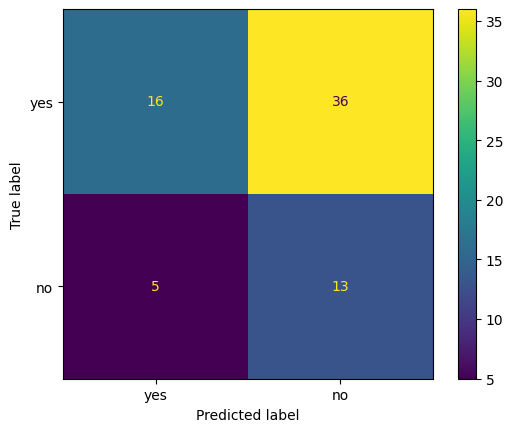

In [5]:
heuristic_approach = purpose_with_label.with_columns(
    pl.when(pl.col("created") > 0.98)
    .then(pl.lit("yes"))
    .otherwise(pl.lit("no"))
    .alias("predicted_label")
)

print(classification_report(
    y_true=heuristic_approach["predicted_label"].to_list(),
    y_pred=heuristic_approach["label"].to_list(),
    labels=["yes", "no"],
))

ConfusionMatrixDisplay.from_predictions(
    y_true=heuristic_approach["label"].to_list(),
    y_pred=heuristic_approach["predicted_label"].to_list(),
    labels=["yes", "no"],
)

In [6]:
heuristic_approach.filter(
    pl.col("predicted_label") == "no",
    pl.col("label") == "yes",
).select(
    "created",
    "shared",
    "used",
).describe()

statistic,created,shared,used
str,f64,f64,f64
"""count""",36.0,36.0,36.0
"""null_count""",0.0,0.0,0.0
"""mean""",0.139724,0.865128,0.405914
"""std""",0.276353,0.263377,0.456437
"""min""",0.000009,0.000002,0.000052
"""25%""",0.000143,0.920741,0.003668
"""50%""",0.001198,0.974265,0.090296
"""75%""",0.057657,0.990004,0.944114
"""max""",0.962179,0.996246,0.999995


In [ ]:
# Train logit from sklearn for best
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split

modeling_approach = purpose_with_label.with_columns(
    (pl.col("used") * pl.col("shared")).alias("used_shared"),
    (pl.col("created") * pl.col("shared")).alias("created_shared"),
    (pl.col("used") * pl.col("created")).alias("used_created"),
)

train_data, test_data = train_test_split(
    modeling_approach.select(
        "shared",
        "created",
        "used",
        "used_shared",
        "created_shared",
        "used_created",
        "label",
    ),
    test_size=0.2,
    random_state=12,
    stratify=modeling_approach["label"].to_list(),
)

logit = LogisticRegressionCV(
    max_iter=1000,
    random_state=12,
    # class_weight="balanced",
    fit_intercept=False,
).fit(
    train_data.select(
        "shared",
        "created",
        "used",
        "used_shared",
        "created_shared",
        "used_created",
    ),
    train_data["label"].to_list(),
)

print(classification_report(
    test_data["label"].to_list(),
    logit.predict(test_data.select(
        "shared",
        "created",
        "used",
        "used_shared",
        "created_shared",
        "used_created",
    )),
    labels=["yes", "no"],
))

ConfusionMatrixDisplay.from_predictions(
    test_data["label"].to_list(),
    logit.predict(test_data.select(
        "shared",
        "created",
        "used",
        "used_shared",
        "created_shared",
        "used_created",
    )),
    labels=["yes", "no"],
)